In [2]:
import os
import cv2 
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle
from skimage.morphology import erosion, opening, square, disk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def readSortedSlices(path):
    
    slices = []
    for s in os.listdir(path):
        slices.append(path + '/' + s)       
    slices.sort(key = lambda s: int(s[s.find('_') + 1 : s.find('.')]))
    ID = slices[0][slices[0].find('/') + 1 : slices[0].find('_')]
    print('CT scan of Patient %s consists of %d slices.' % (ID, len(slices)))  
    return (slices, ID)

def getSliceImages(slices):
    
    return list(map(readImg, slices))

def readImg(path, showOutput=0):
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if showOutput:
        plt.title('A CT Scan Image Slice')
        plt.imshow(img, cmap='gray')
    return img

In [15]:
slices, PatientID = readSortedSlices('sample-dataset')
sliceImgs = getSliceImages(slices)

CT scan of Patient home/nushkash/PES1UG19CS078/4 IPCV Lab/Project - Cardiac Segmentation/cardiac-segmentation/sample-dataset/ID00007637202177411956430 consists of 30 slices.


[ WARN:0@282.761] global /home/conda/feedstock_root/build_artifacts/libopencv_1641992572912/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('~/PES1UG19CS078/4 IPCV Lab/Project - Cardiac Segmentation/cardiac-segmentation//home/nushkash/PES1UG19CS078/4 IPCV Lab/Project - Cardiac Segmentation/cardiac-segmentation/sample-dataset/ID00007637202177411956430_0.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.5.5) /home/conda/feedstock_root/build_artifacts/libopencv_1641992572912/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [5]:
# Select a sample slice to work with
plt.figure(figsize = (12, 6))
im = readImg('sample-dataset/ID00007637202177411956430_16.jpg')
plt.title('Original CT Image')
plt.imshow(im, cmap='gray')

[ WARN:0@40.124] global /home/conda/feedstock_root/build_artifacts/libopencv_1641992572912/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../sample-dataset/ID00007637202177411956430_16.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.5.5) /home/conda/feedstock_root/build_artifacts/libopencv_1641992572912/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


<Figure size 864x432 with 0 Axes>

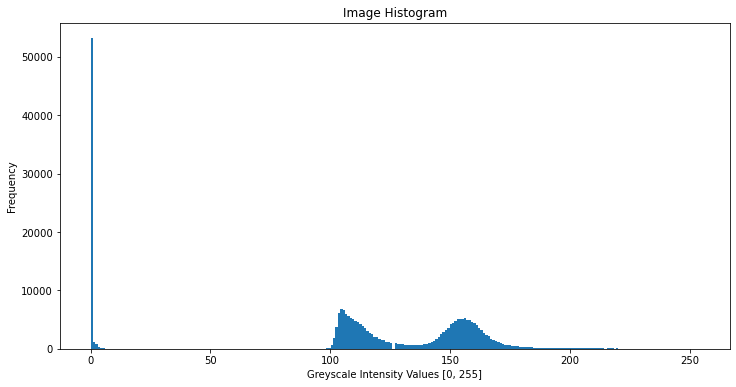

In [47]:
plt.figure(figsize = (12, 6))

plt.title('Image Histogram')
plt.xlabel('Greyscale Intensity Values [0, 255]')
plt.ylabel('Frequency')
plt.hist(im.ravel(), bins=256)
plt.show()

In [6]:
im.shape

(512, 512)

In [7]:
imflat = np.reshape(im, im.shape[0] * im.shape[1]).reshape(-1, 1)
print(imflat.shape)
imflat

(262144, 1)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

In [53]:
def applyKMeans(img, n_clust):
    
    imflat = np.reshape(im, im.shape[0] * im.shape[1]).reshape(-1, 1)
        
    kmeans = KMeans(n_clust)
    
    kmmodel = kmeans.fit(imflat)
    
    labels = kmmodel.labels_
    centers = kmmodel.cluster_centers_
    
    print(len(labels), 'Labels: \n', labels)
    
    # Center values correspond to intensity values 
    print(len(centers), 'Centers: \n', centers)
    
    # Print centers of labels
    centers_map = dict(zip(np.arange(n_clust), centers))
    print('Labels with corresponding centers:', centers_map)
    
    segmented = np.array([centers_map[label] for label in labels]).reshape(img.shape[0], img.shape[1]) 

    segmented = segmented.astype(int)
    
    # Plot the segmented image
    plt.figure(figsize = (12, 6))
    
    plt.title('CT Image on Segmentation with KMeans of K = ' + str(n_clust))
    plt.imshow(segmented)
    
    return segmented, labels, centers_map

262144 Labels: 
 [1 1 1 ... 1 1 1]
2 Centers: 
 [[1.36680242e+02]
 [8.82521695e-02]]
Labels with corresponding centers: {0: array([136.68024247]), 1: array([0.08825217])}


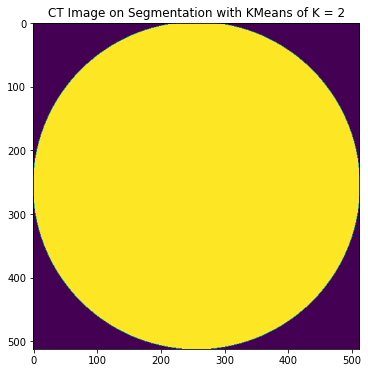

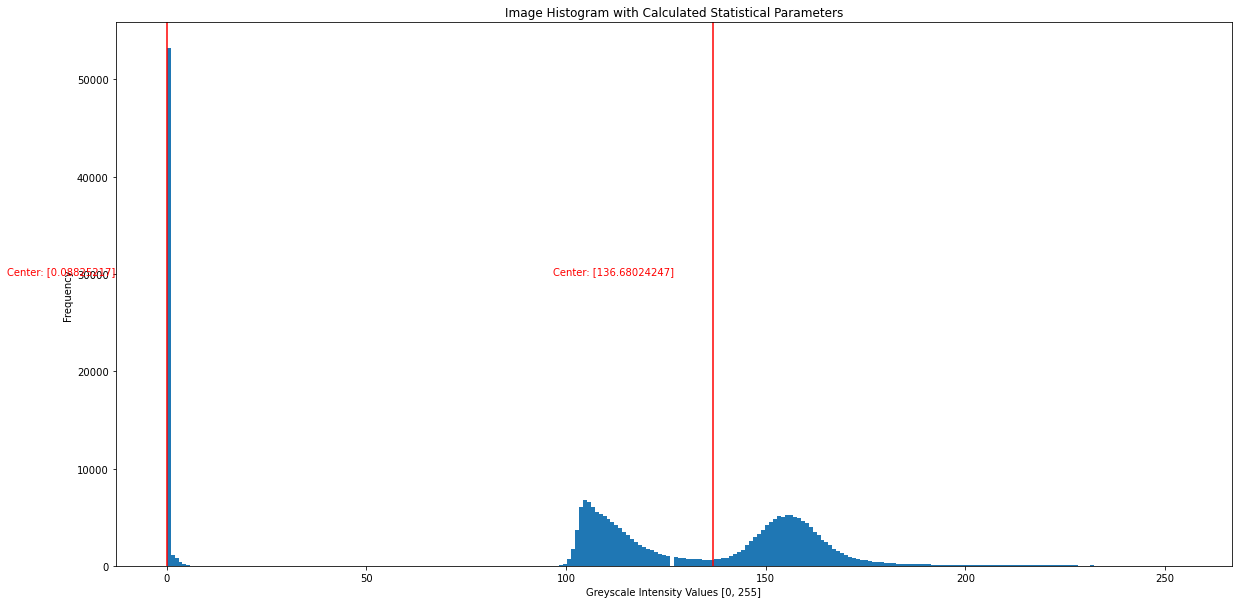

In [61]:
air_mask, labels, centers_air = applyKMeans(im, 2)

plt.figure(figsize = (20, 10))

# Mean line
for center in centers_air.values():
    plt.axvline(x = center, c = 'red')
    plt.text(x = center - 40, 
             y = 30000, 
             s = "Center: " + str(center), 
             c = 'red')

plt.title('Image Histogram with Calculated Statistical Parameters')
plt.xlabel('Greyscale Intensity Values [0, 255]')
plt.ylabel('Frequency')
plt.hist(im.ravel(), bins=256)
plt.show()

262144 Labels: 
 [1 1 1 ... 1 1 1]
3 Centers: 
 [[1.57879115e+02]
 [8.82521695e-02]
 [1.12269714e+02]]
Labels with corresponding centers: {0: array([157.87911491]), 1: array([0.08825217]), 2: array([112.26971435])}


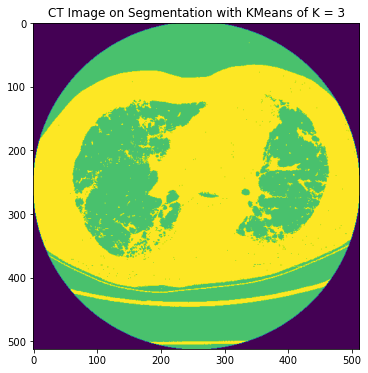

In [62]:
foreground_mask, labels, centers = applyKMeans(im, 3)

TypeError: list indices must be integers or slices, not str

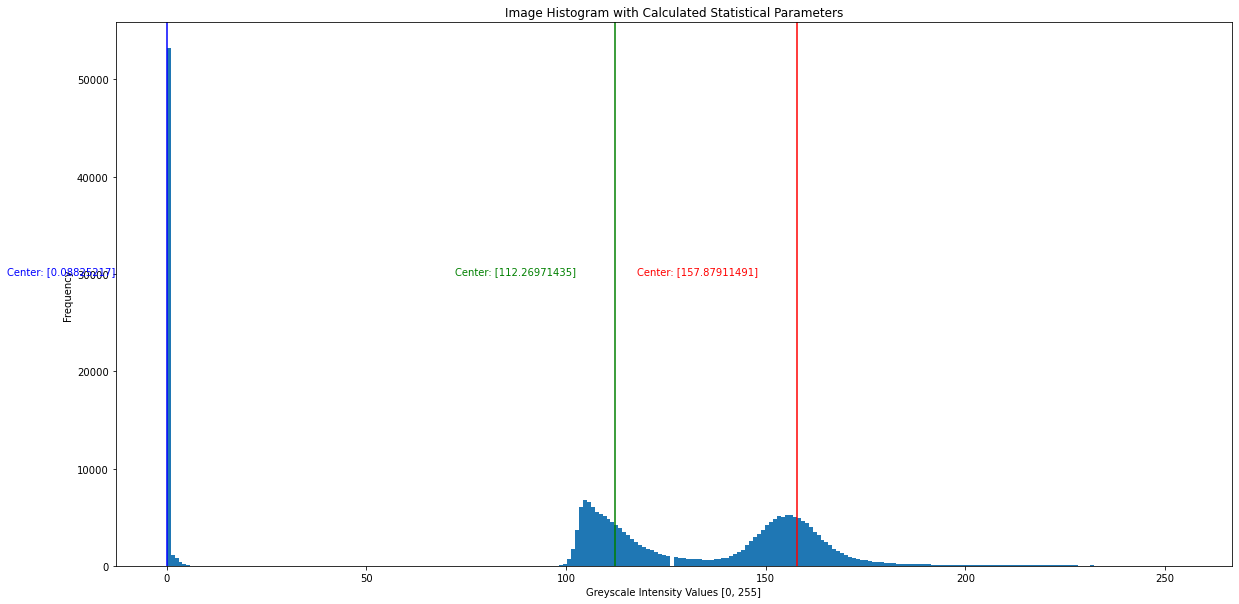

In [74]:
plt.figure(figsize = (20, 10))

# Mean line
colors = ['red', 'blue', 'green']; i = 0
for center in centers.values():
    plt.axvline(x = center, c = colors[i])
    plt.text(x = center + 30, 
             y = 30000, 
             s = "Center: " + str(center), 
             c = colors[i])
    i += 1

plt.title('Image Histogram')
plt.xlabel('Greyscale Intensity Values [0, 255]')
plt.ylabel('Frequency')

vals = sorted(center.values())
threshold = (vals[1] + vals[2])/2

plt.axvline(x = threshold, c = 'black')
plt.text(x = threshold + 30, 
         y = 30000, 
         s = "Threshold", 
         c = 'black')
plt.show()

In [44]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, 
                                   figsize=(12, 6), 
                                   sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

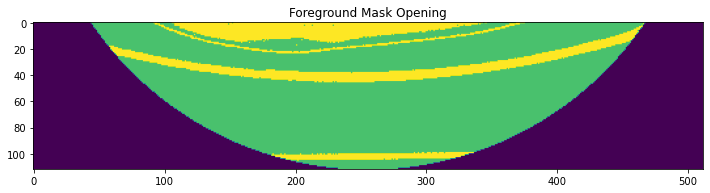

In [21]:
test = foreground_mask[400:, :]

# Plot the segmented image
plt.figure(figsize = (12, 6))

plt.title('Foreground Mask Opening')
plt.imshow(test)

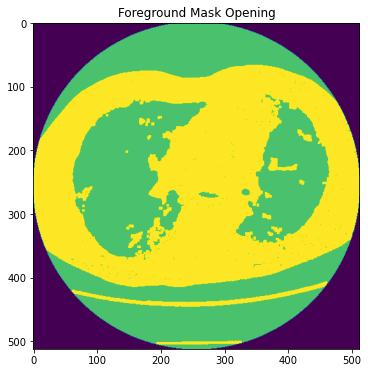

In [43]:
# F = opening(opening(foreground_mask,  disk(1)),  disk(1))
F = opening(opening(foreground_mask, square(4)), square(4))

plot_comparison()

262144 Labels: 
 [1 1 1 ... 1 1 1]
4 Centers: 
 [[1.54417920e+02]
 [8.82521695e-02]
 [1.11976878e+02]
 [1.84699907e+02]]
Labels with corresponding centers: {0: array([154.41792046]), 1: array([0.08825217]), 2: array([111.97687806]), 3: array([184.6999068])}


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

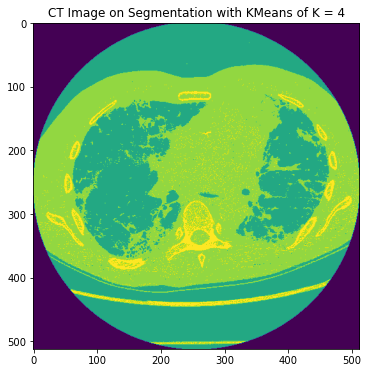

In [31]:
applyKMeans(F, 4)

262144 Labels: 
 [1 1 1 ... 1 1 1]
4 Centers: 
 [[1.11976878e+02]
 [8.82521695e-02]
 [1.54417920e+02]
 [1.84699907e+02]]
Labels with corresponding centers: {0: array([111.97687806]), 1: array([0.08825217]), 2: array([154.41792046]), 3: array([184.6999068])}


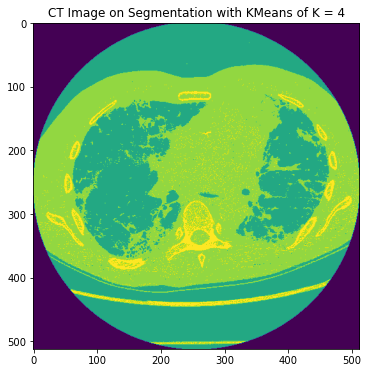

In [135]:
applyKMeans(im, 4)

262144 Labels: 
 [1 1 1 ... 1 1 1]
5 Centers: 
 [[1.60520141e+02]
 [8.82521695e-02]
 [1.11234871e+02]
 [1.45329494e+02]
 [1.97892509e+02]]
Labels with corresponding centers: {0: array([160.52014142]), 1: array([0.08825217]), 2: array([111.23487119]), 3: array([145.32949364]), 4: array([197.89250874])}


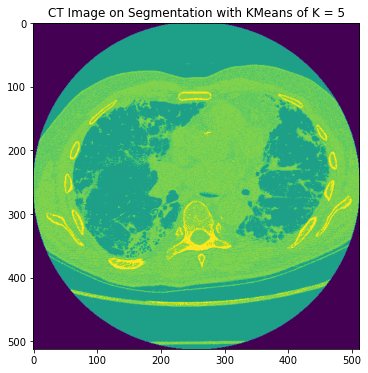

In [136]:
applyKMeans(im, 5)